In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split

sns.set(style='darkgrid')
filterwarnings('ignore')

In [2]:
X = load_npz('x.npz')
y = np.load('y.npy')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1337)

X_train.shape, X_valid.shape, X_test.shape

((18825, 169), (2354, 169), (2353, 169))

In [4]:
X_train

<18825x169 sparse matrix of type '<class 'numpy.float64'>'
	with 119106 stored elements in Compressed Sparse Row format>

In [5]:
X_train = X_train.toarray()
X_valid = X_valid.toarray()
X_test = X_test.toarray()

In [30]:
y_test

array([1, 0, 1, ..., 1, 1, 0])

In [31]:
y_train = 2 * y_train - 1
y_valid = 2 * y_valid - 1
y_test = 2 * y_test - 1

In [6]:
%load_ext autoreload

In [ ]:
from __future__ import annotations

from collections import defaultdict

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
import tqdm
import matplotlib.pyplot as plt
import optuna
from typing import Optional

def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])

class Boosting:
    def __init__(
        self,
        base_model_class = DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        bootstrap_type: str | None = 'Bernoulli',
        subsample: int | float = 1.0,
        bagging_temperature: float = 1.0,
        quantization_type: str | None = None,
        nbins: int = 255,
        rsm: float = 1.0
    ):
        self.base_model_class = base_model_class
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = []
        self.feat_positions: list = []
        self.gammas: list = []

        self.lr: float = learning_rate
        self.bootstrap_type = bootstrap_type
        self.subsample = subsample
        self.bagging_temperature = bagging_temperature
        self.quantization_type = quantization_type
        self.rsm = rsm
        self.nbins = nbins
        self.quant_bins = []
        self.feature_importances_ = None

        self.history = defaultdict(list) # {"train_roc_auc": [], "train_loss": [], ...}

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * (1 - self.sigmoid(y*z))  # Исправьте формулу на правильную. 

    def partial_fit(self, X, y, weight=None):
        base_model = self.base_model_class(**self.base_model_params)
        base_model.fit(X, y, weight)
        return base_model
    
    def get_quants(self, X):
        if len(self.quant_bins) != 0:
            res = np.zeros(X.shape)
            for ind in range(X.shape[1]):
                res[:, ind] = np.searchsorted(self.quant_bins[ind], X[:, ind])
            return res
        else:
            return X

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, plot=False, early_stopping_rounds=None, trial=None):
        """
        :param X_train: features array (train set)
        :param y_train: targets array (train set)
        :param X_val: features array (eval set)
        :param y_val: targets array (eval set)
        :param plot: bool 
        """

        n_obj = X_train.shape[0]
        n_feat = X_train.shape[1]
        train_preds = np.zeros(n_obj)

        is_valid = X_valid is not None and y_valid is not None
        if is_valid:
            n_val_obj = X_valid.shape[0]
            valid_preds = np.zeros(n_val_obj)

        if self.quantization_type == 'Uniform':
            for ind in range(n_feat):
                self.quant_bins.append(np.linspace(X_train[:, ind].min(), X_train[:, ind].max(), self.nbins + 1)[1:-1])
        elif self.quantization_type == 'Quantile':
            for ind in range(n_feat):
                vals = np.sort(X_train[:, ind])
                idx = np.linspace(0, vals.shape[0], self.nbins + 1)[1:-1]
                self.quant_bins.append(vals[idx.astype(int)])

        X_train = self.get_quants(X_train)
        if is_valid:
            X_valid = self.get_quants(X_valid)

        for epoch in tqdm.tqdm(range(self.n_estimators)):
            cnt = int(self.rsm * n_feat) if type(self.rsm) is float else self.rsm
            feat_pos = np.sort(np.random.choice(n_feat, cnt, replace=False))

            weight = np.ones(n_obj)
            if self.bootstrap_type == 'Bernoulli':
                cnt = int((1 - self.subsample) * n_obj) if type(self.subsample) is float else self.subsample
                weight[np.random.choice(n_obj, cnt, replace=False)] = 0
            elif self.bootstrap_type == 'Bayesian':
                weight = (-np.log(np.random.uniform(0, 1, n_obj))) ** self.bagging_temperature
                
            s_N = -self.loss_derivative(y_train, train_preds)
            model = self.partial_fit(X_train[:, feat_pos], s_N, weight)
            b_N = model.predict(X_train[:, feat_pos])
            gamma = self.find_optimal_gamma(y_train, train_preds, b_N)
            train_preds += self.lr * gamma * b_N
            self.feat_positions.append(feat_pos)
            self.models.append(model)
            self.gammas.append(gamma)
            self.history['train_loss'] += [self.loss_fn(y_train, train_preds)]
            self.history['train_roc_auc'] += [roc_auc_score(y_train, self.sigmoid(train_preds))]

            if is_valid:
                valid_preds += self.lr * gamma * model.predict(X_valid[:, feat_pos])
                self.history['valid_loss'] += [self.loss_fn(y_valid, valid_preds)]
                self.history['valid_roc_auc'] += [roc_auc_score(y_valid, self.sigmoid(valid_preds))]

                if early_stopping_rounds is not None and epoch >= early_stopping_rounds:
                    epoch_loss = self.history['valid_loss'][-early_stopping_rounds-1:]
                    if np.all(epoch_loss[:-1] <= epoch_loss[1:]):
                        print(f"Early stopping, epoch: {epoch+1}/{self.n_estimators}")
                        break

                if trial is not None:
                    trial.report(self.history['valid_roc_auc'][-1], epoch)
                    if trial.should_prune():
                        raise optuna.TrialPruned()

        self.feature_importances_ = np.zeros(n_feat)
        for model, feat_pos in zip(self.models, self.feat_positions):
            self.feature_importances_[feat_pos] += model.feature_importances_
        self.feature_importances_ /= self.feature_importances_.sum()

        if plot:
            _, axs = plt.subplots(1, 2, figsize=(18, 7))
            axs[0].plot(self.history['train_loss'], label='train loss')
            axs[1].plot(self.history['train_roc_auc'], label='train ROC AUC')
            if is_valid:
                axs[0].plot(self.history['valid_loss'], label='valid loss')
                axs[1].plot(self.history['valid_roc_auc'], label='valid ROC AUC')

            axs[0].set_xlabel('Epoch count')
            axs[1].set_xlabel('Epoch count')

            axs[0].set_ylabel('loss')
            axs[1].set_ylabel('ROC AUC')
            axs[0].set_title('Plot of Loss')
            axs[1].set_title('Plot of ROC AUC')
            plt.legend()
            plt.show()                


    def predict_proba(self, X):
        X = self.get_quants(X)
        preds = np.zeros(X.shape[0])
        for model, gamma, feat_pos in zip(self.models, self.gammas, self.feat_positions):
            preds += self.lr * gamma * model.predict(X[:, feat_pos])
        
        return np.array([1 - self.sigmoid(preds), self.sigmoid(preds)]).T

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def score(self, X, y):
        return score(self, X, y)
        
    def plot_history(self, X, y, plot_name=''):
        """
        :param X: features array (any set)
        :param y: targets array (any set)
        """
        X = self.get_quants(X)
        loss = []
        roc_auc = []
        preds = np.zeros(X.shape[0])
        for model, gamma, feat_pos in zip(self.models, self.gammas, self.feat_positions):
            preds += self.lr * gamma * model.predict(X[:, feat_pos])
            loss.append(self.loss_fn(y, preds))
            roc_auc.append(roc_auc_score(y, self.sigmoid(preds)))

        _, axs = plt.subplots(1, 2, figsize=(18, 7))
        axs[0].plot(loss)
        axs[1].plot(roc_auc)
        axs[0].set_xlabel('Epoch count')
        axs[1].set_xlabel('Epoch count')
        axs[0].set_ylabel('loss')
        axs[1].set_ylabel('ROC AUC')
        axs[0].set_title(plot_name)
        axs[1].set_title(plot_name)
        plt.show()                

### Проверка кода

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


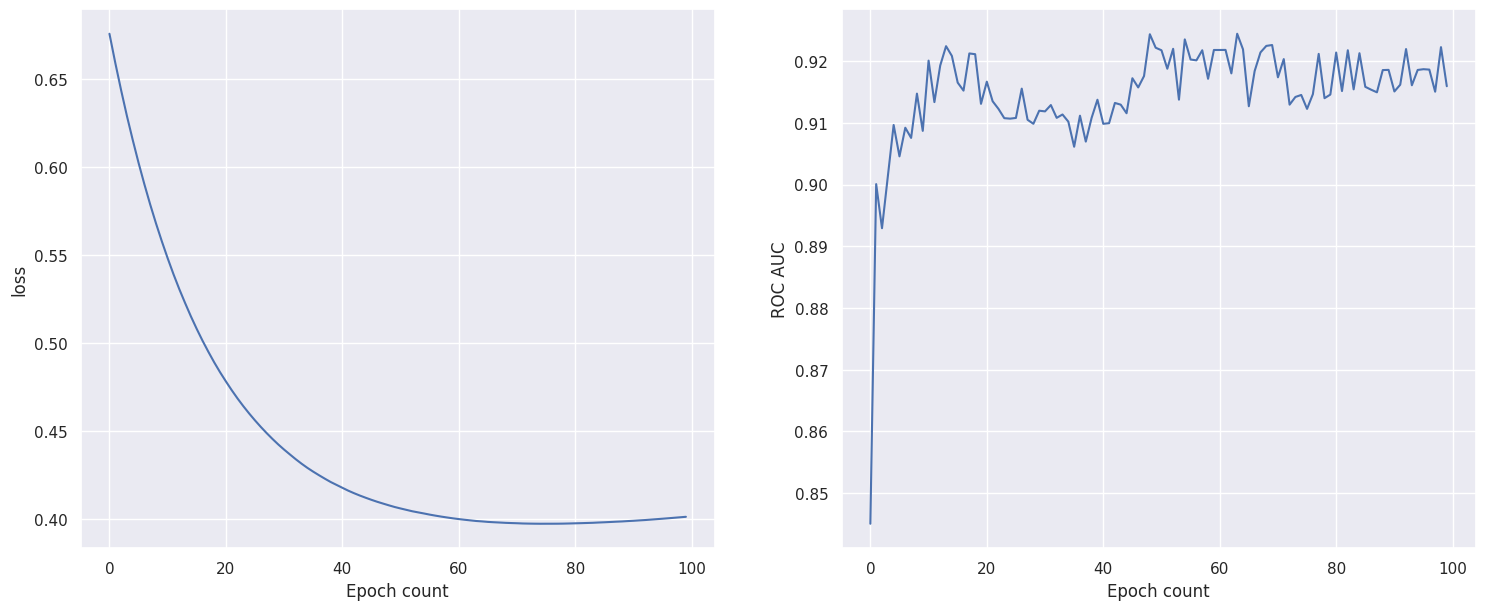

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9160
Test ROC-AUC 0.9113


In [32]:
boosting = Boosting(n_estimators=100)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

# early_stopping_rounds

 79%|███████▉  | 79/100 [00:41<00:11,  1.89it/s]

Early stopping, epoch: 80/100


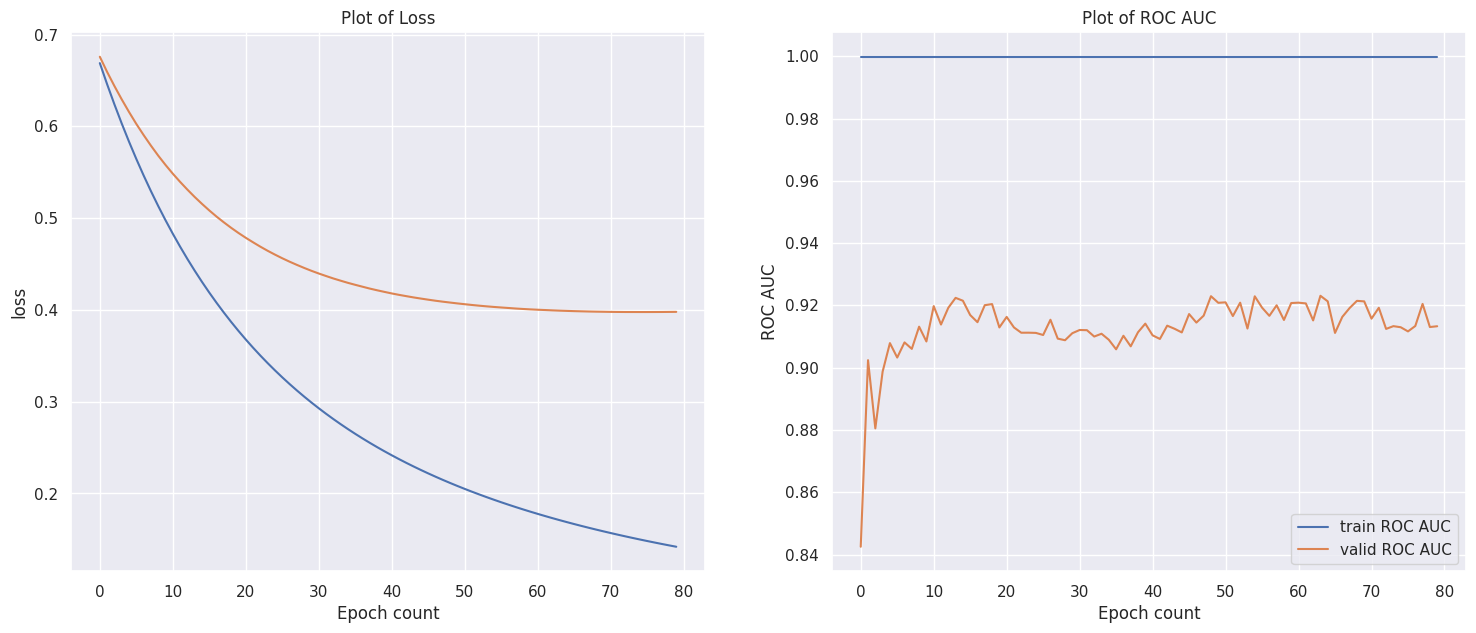

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9133
Test ROC-AUC 0.9088


In [38]:
boosting = Boosting(n_estimators=100)
boosting.fit(X_train, y_train, X_valid, y_valid, early_stopping_rounds=5, plot=True)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

# different bootstraps

100%|██████████| 100/100 [00:30<00:00,  3.25it/s]


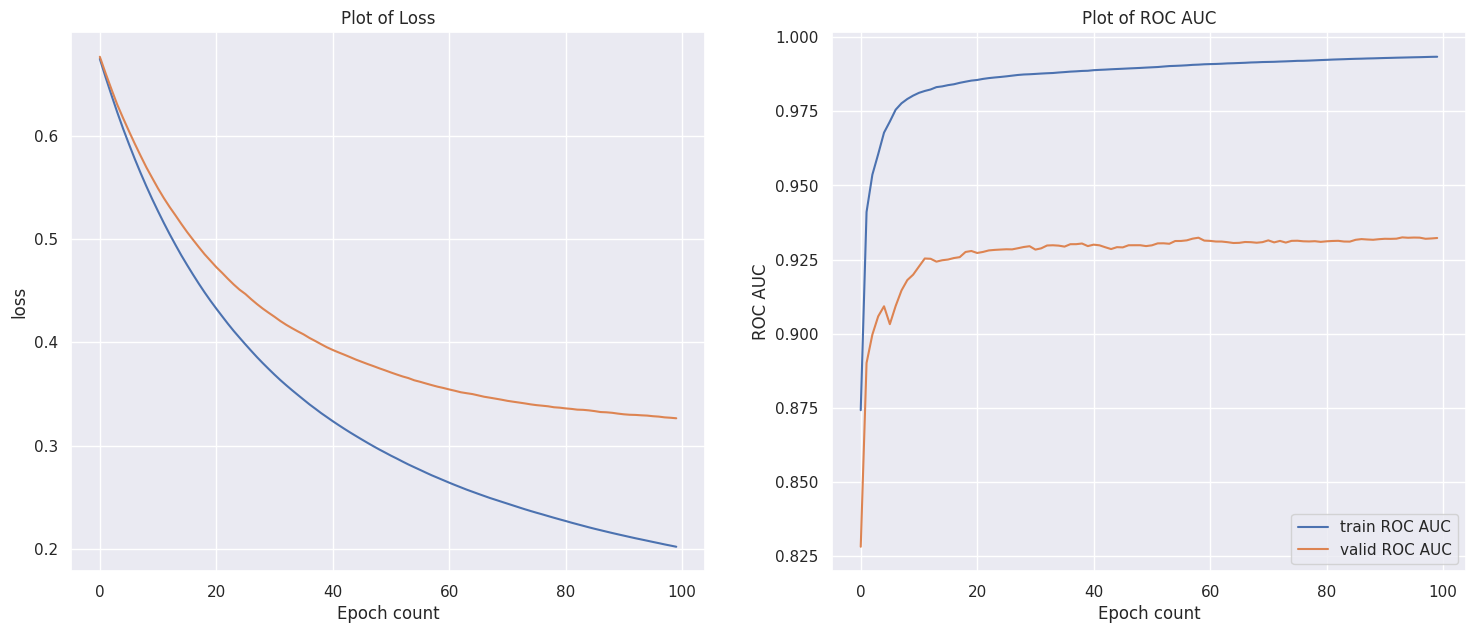

Train ROC-AUC 0.9934
Valid ROC-AUC 0.9323
Test ROC-AUC 0.9336


In [39]:
boosting = Boosting(n_estimators=100, subsample=0.15)
boosting.fit(X_train, y_train, X_valid, y_valid, early_stopping_rounds=5, plot=True)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

# features bootstrap and uniform/quantile quantization


100%|██████████| 100/100 [00:13<00:00,  7.42it/s]


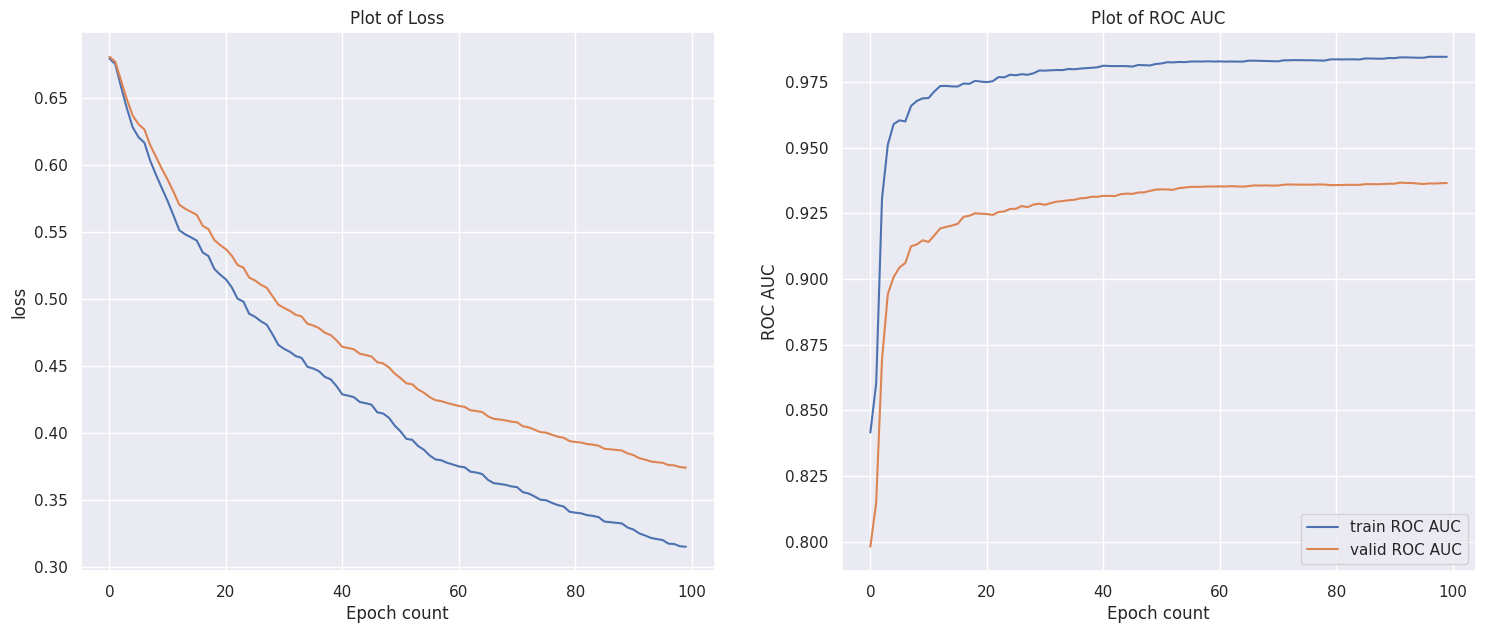

Train ROC-AUC 0.9845
Valid ROC-AUC 0.9365
Test ROC-AUC 0.9311


In [73]:
boosting = Boosting(n_estimators=100, subsample=0.15, rsm=0.3, quantization_type='Quantile')
boosting.fit(X_train, y_train, X_valid, y_valid, early_stopping_rounds=5, plot=True)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

# feature_importances

100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


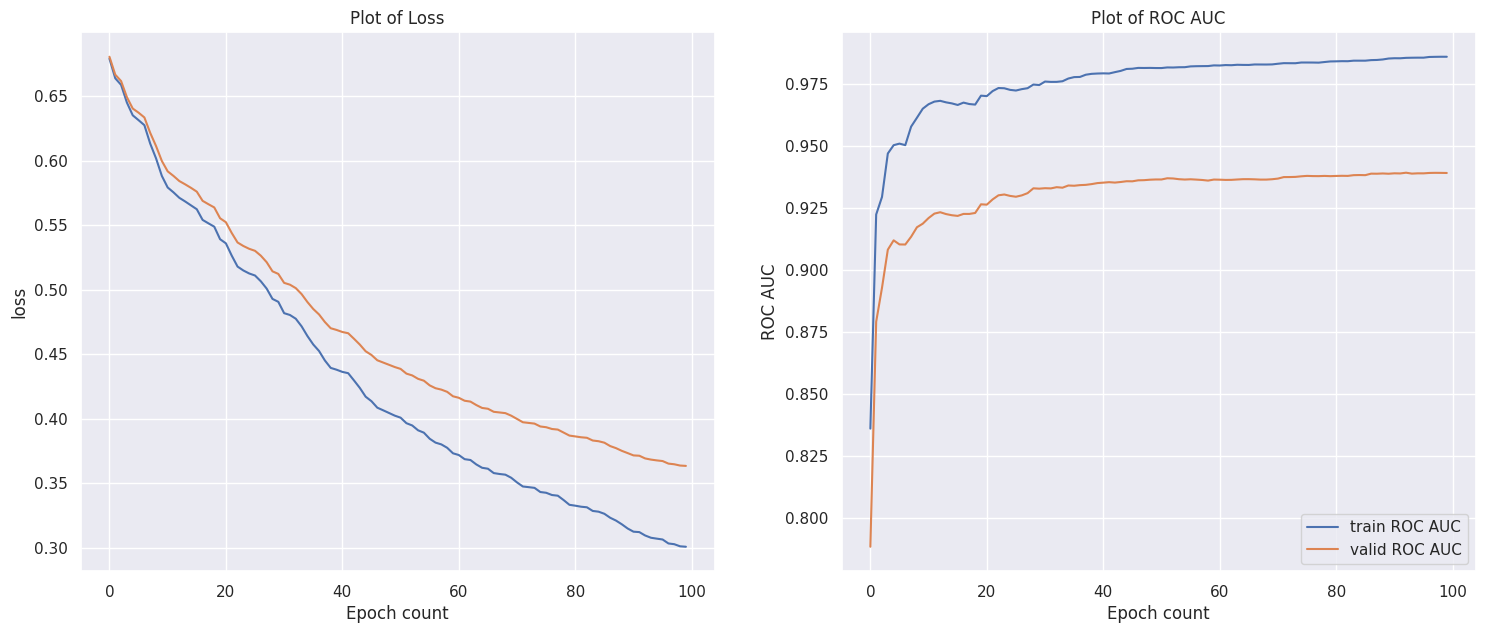

In [74]:
boosting = Boosting(n_estimators=100, subsample=0.15, rsm=0.3, quantization_type='Quantile')
boosting.fit(X_train, y_train, X_valid, y_valid, early_stopping_rounds=5, plot=True)

Самые важные признаки:

In [75]:
np.arange(len(boosting.feature_importances_))[boosting.feature_importances_ > 0.01]

array([  2,  10,  24,  27, 147, 155, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168])

In [77]:
import optuna

def objective(trial, model="custom_boosting"):
    np.random.seed(666)
    n_estimators = trial.suggest_int('n_estimators', 10, 30)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 1, log=True)
    subsample = trial.suggest_float('subsample', 0.1, 1)
    nbins = trial.suggest_int('nbins', 10, 500)
    rsm = trial.suggest_float('rsm', 0.1, 1)
    boosting = Boosting(n_estimators=n_estimators, 
                        learning_rate=learning_rate, 
                        subsample=subsample, 
                        nbins=nbins, 
                        quantization_type='Quantile', 
                        rsm=rsm)
    boosting.fit(X_train, y_train, X_valid, y_valid, plot=False, early_stopping_rounds=5)

    return -boosting.score(X_valid, y_valid)

study = optuna.create_study()
study.optimize(objective, n_trials=10, show_progress_bar=True)
best_params = study.best_params
optuna.importance.get_param_importances(study)

[I 2024-12-23 23:38:22,827] A new study created in memory with name: no-name-f6f6c3e1-9978-4fcc-a8d0-ec50afe1da95
  0%|          | 0/10 [00:00<?, ?it/s]

Best trial: 0. Best value: -0.934375:  10%|█         | 1/10 [00:03<00:34,  3.80s/it]

[I 2024-12-23 23:38:26,630] Trial 0 finished with value: -0.9343747331048909 and parameters: {'n_estimators': 18, 'learning_rate': 0.004372838839400846, 'subsample': 0.1616166838314009, 'nbins': 141, 'rsm': 0.7155017845377027}. Best is trial 0 with value: -0.9343747331048909.


Best trial: 0. Best value: -0.934375:  20%|██        | 2/10 [00:16<01:13,  9.14s/it]

[I 2024-12-23 23:38:39,511] Trial 1 finished with value: -0.921713827780718 and parameters: {'n_estimators': 22, 'learning_rate': 0.00021256183504911395, 'subsample': 0.8321865341558223, 'nbins': 243, 'rsm': 0.9743578854479319}. Best is trial 0 with value: -0.9343747331048909.


Best trial: 2. Best value: -0.934684:  30%|███       | 3/10 [00:22<00:54,  7.74s/it]

[I 2024-12-23 23:38:45,583] Trial 2 finished with value: -0.9346844312051168 and parameters: {'n_estimators': 30, 'learning_rate': 0.00013163695654001614, 'subsample': 0.2530113144840529, 'nbins': 421, 'rsm': 0.38850087633094377}. Best is trial 2 with value: -0.9346844312051168.


Best trial: 2. Best value: -0.934684:  40%|████      | 4/10 [00:24<00:31,  5.28s/it]

[I 2024-12-23 23:38:47,088] Trial 3 finished with value: -0.9274464353988121 and parameters: {'n_estimators': 14, 'learning_rate': 0.024003778379135313, 'subsample': 0.19554148935524696, 'nbins': 275, 'rsm': 0.5191532171394417}. Best is trial 2 with value: -0.9346844312051168.


Best trial: 2. Best value: -0.934684:  50%|█████     | 5/10 [00:26<00:20,  4.02s/it]

[I 2024-12-23 23:38:48,877] Trial 4 finished with value: -0.9244284753035719 and parameters: {'n_estimators': 12, 'learning_rate': 0.0033499637699138402, 'subsample': 0.9179866410255682, 'nbins': 68, 'rsm': 0.3701339144627156}. Best is trial 2 with value: -0.9346844312051168.


Best trial: 5. Best value: -0.935277:  60%|██████    | 6/10 [00:31<00:17,  4.40s/it]

[I 2024-12-23 23:38:54,001] Trial 5 finished with value: -0.9352774871032293 and parameters: {'n_estimators': 28, 'learning_rate': 0.0007350135929906916, 'subsample': 0.42188420608030996, 'nbins': 463, 'rsm': 0.6433540193239038}. Best is trial 5 with value: -0.9352774871032293.


Best trial: 5. Best value: -0.935277:  70%|███████   | 7/10 [00:32<00:10,  3.41s/it]

[I 2024-12-23 23:38:55,393] Trial 6 finished with value: -0.9303905628284057 and parameters: {'n_estimators': 21, 'learning_rate': 0.0012403162334067683, 'subsample': 0.14963431731196963, 'nbins': 182, 'rsm': 0.15072098620358146}. Best is trial 5 with value: -0.9352774871032293.


Best trial: 5. Best value: -0.935277:  80%|████████  | 8/10 [00:38<00:08,  4.16s/it]

[I 2024-12-23 23:39:01,162] Trial 7 finished with value: -0.9260827261095453 and parameters: {'n_estimators': 24, 'learning_rate': 0.00023581939386466315, 'subsample': 0.527955667701969, 'nbins': 151, 'rsm': 0.880699145613174}. Best is trial 5 with value: -0.9352774871032293.


Best trial: 5. Best value: -0.935277:  90%|█████████ | 9/10 [00:41<00:03,  3.83s/it]

[I 2024-12-23 23:39:04,245] Trial 8 finished with value: -0.9326430577738614 and parameters: {'n_estimators': 15, 'learning_rate': 0.009259783405733506, 'subsample': 0.4937575369581031, 'nbins': 78, 'rsm': 0.6145839117808737}. Best is trial 5 with value: -0.9352774871032293.


Best trial: 9. Best value: -0.936084: 100%|██████████| 10/10 [00:43<00:00,  4.37s/it]


[I 2024-12-23 23:39:06,504] Trial 9 finished with value: -0.9360840590884818 and parameters: {'n_estimators': 22, 'learning_rate': 0.026106395853993207, 'subsample': 0.587616085941739, 'nbins': 19, 'rsm': 0.27870817459216474}. Best is trial 9 with value: -0.9360840590884818.


{'subsample': 0.4120836612747508,
 'rsm': 0.25252396740951355,
 'n_estimators': 0.24580802994114753,
 'nbins': 0.07655917114152136,
 'learning_rate': 0.013025170233066662}

100%|██████████| 22/22 [00:02<00:00,  9.89it/s]


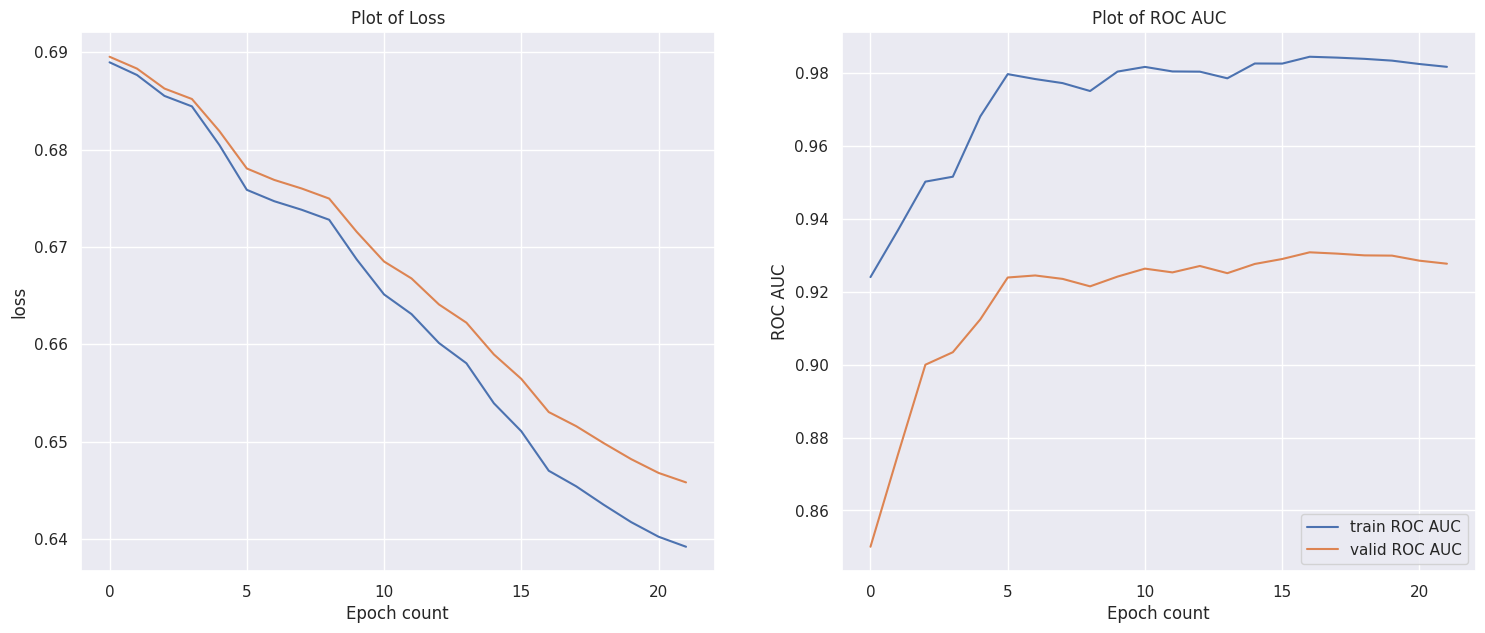

100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


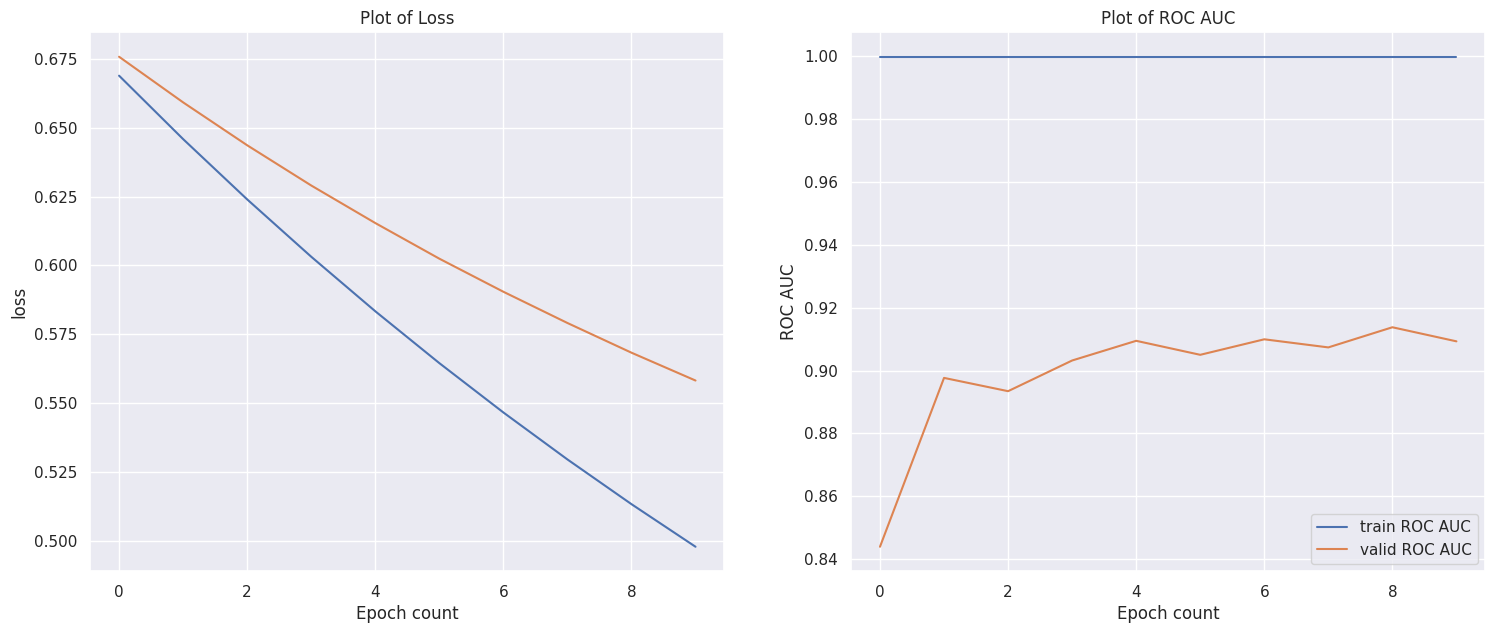

In [78]:
boosting = Boosting(n_estimators=best_params['n_estimators'], 
                    subsample=best_params['subsample'], 
                    rsm=best_params['rsm'],
                    nbins=best_params['nbins'],
                    learning_rate=best_params['learning_rate'])
boosting.fit(X_train, y_train, X_valid, y_valid, plot=True)
boosting = Boosting()
boosting.fit(X_train, y_train, X_valid, y_valid, plot=True)

# deep statistical optimization, optuna pruners

In [79]:
import time
def objective(trial, model="custom_boosting"):
    np.random.seed(666)
    n_estimators = trial.suggest_int('n_estimators', 10, 30)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 1, log=True)
    subsample = trial.suggest_float('subsample', 0.1, 1)
    nbins = trial.suggest_int('nbins', 10, 500)
    rsm = trial.suggest_float('rsm', 0.1, 1)
    boosting = Boosting(n_estimators=n_estimators, 
                        learning_rate=learning_rate, 
                        subsample=subsample, 
                        nbins=nbins, 
                        quantization_type='Quantile', 
                        rsm=rsm)
    boosting.fit(X_train, y_train, X_valid, y_valid, plot=False, trial=trial)
    start = time.time()
    study.set_user_attr('valid', boosting.history['val_loss'])
    study.set_user_attr('train', boosting.history['train_loss'])
    study.set_user_attr('time', time.time() - start)

    return -boosting.score(X_valid, y_valid)

storage = optuna.storages.InMemoryStorage()
study = optuna.create_study(storage=storage)
study.optimize(objective, n_trials=10)

[I 2024-12-23 23:41:23,176] A new study created in memory with name: no-name-859c4f42-a5a9-423c-b9a7-8f7f64fa2dca
100%|██████████| 13/13 [00:02<00:00,  4.72it/s]
[I 2024-12-23 23:41:26,218] Trial 0 finished with value: -0.9268956836226376 and parameters: {'n_estimators': 13, 'learning_rate': 0.9675236303346169, 'subsample': 0.8635836791892972, 'nbins': 269, 'rsm': 0.6023068352442765}. Best is trial 0 with value: -0.9268956836226376.
100%|██████████| 18/18 [00:03<00:00,  4.64it/s]
[I 2024-12-23 23:41:30,294] Trial 1 finished with value: -0.9271151861421275 and parameters: {'n_estimators': 18, 'learning_rate': 0.11247144378852506, 'subsample': 0.7176592319274095, 'nbins': 278, 'rsm': 0.6478226540278058}. Best is trial 1 with value: -0.9271151861421275.
100%|██████████| 17/17 [00:01<00:00,  8.94it/s]
[I 2024-12-23 23:41:32,371] Trial 2 finished with value: -0.9289023357462647 and parameters: {'n_estimators': 17, 'learning_rate': 0.5095952038857903, 'subsample': 0.8816317745434464, 'nbins'

Ускорилась

# catboost comparison

In [80]:
import catboost

def objective(trial, model="catboost"):
    np.random.seed(666)
    n_estimators = trial.suggest_int('n_estimators', 10, 30)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 1, log=True)
    subsample = trial.suggest_float('subsample', 0.1, 1)
    rsm = trial.suggest_float('rsm', 0.1, 1)
    boosting = catboost.CatBoostClassifier(iterations=n_estimators, 
                                           learning_rate=learning_rate, 
                                           subsample=subsample, 
                                           rsm=rsm, 
                                           random_seed=666)
    start = time.time()
    boosting.fit(X_train, y_train, eval_set=(X_valid, y_valid))
    study.set_user_attr('valid', boosting.evals_result_['validation']['Logloss'])
    study.set_user_attr('train', boosting.evals_result_['learn']['Logloss'])
    study.set_user_attr('time', time.time() - start)
    return boosting.evals_result_['validation']['Logloss'][-1]

study = optuna.create_study()
study.optimize(objective, n_trials=10)
cat_best = study.best_trial

[I 2024-12-23 23:43:02,234] A new study created in memory with name: no-name-2701e808-8d0d-466b-b7f3-7c54989f56a0
[I 2024-12-23 23:43:03,704] Trial 0 finished with value: 0.2966353944794679 and parameters: {'n_estimators': 28, 'learning_rate': 0.11249447908030534, 'subsample': 0.1522723692152613, 'rsm': 0.30557851471740116}. Best is trial 0 with value: 0.2966353944794679.


0:	learn: 0.5896667	test: 0.5936822	best: 0.5936822 (0)	total: 50.5ms	remaining: 1.36s
1:	learn: 0.5103613	test: 0.5199802	best: 0.5199802 (1)	total: 53.8ms	remaining: 700ms
2:	learn: 0.4536324	test: 0.4668751	best: 0.4668751 (2)	total: 60.9ms	remaining: 507ms
3:	learn: 0.4083506	test: 0.4247675	best: 0.4247675 (3)	total: 64.3ms	remaining: 386ms
4:	learn: 0.3863879	test: 0.4065790	best: 0.4065790 (4)	total: 67.4ms	remaining: 310ms
5:	learn: 0.3602332	test: 0.3844231	best: 0.3844231 (5)	total: 70.5ms	remaining: 259ms
6:	learn: 0.3514940	test: 0.3764392	best: 0.3764392 (6)	total: 76.1ms	remaining: 228ms
7:	learn: 0.3346807	test: 0.3617151	best: 0.3617151 (7)	total: 79.9ms	remaining: 200ms
8:	learn: 0.3208771	test: 0.3505981	best: 0.3505981 (8)	total: 83ms	remaining: 175ms
9:	learn: 0.3116402	test: 0.3432492	best: 0.3432492 (9)	total: 86.1ms	remaining: 155ms
10:	learn: 0.3038499	test: 0.3376997	best: 0.3376997 (10)	total: 90.7ms	remaining: 140ms
11:	learn: 0.2958725	test: 0.3311304	best: 

[I 2024-12-23 23:43:05,167] Trial 1 finished with value: 0.5928592531228153 and parameters: {'n_estimators': 22, 'learning_rate': 0.009598871912568247, 'subsample': 0.8925286054807731, 'rsm': 0.10842900839955012}. Best is trial 0 with value: 0.2966353944794679.


0:	learn: 0.6835885	test: 0.6842469	best: 0.6842469 (0)	total: 9.03ms	remaining: 190ms
1:	learn: 0.6811418	test: 0.6819788	best: 0.6819788 (1)	total: 12.6ms	remaining: 126ms
2:	learn: 0.6719483	test: 0.6733560	best: 0.6733560 (2)	total: 20.7ms	remaining: 131ms
3:	learn: 0.6686238	test: 0.6700010	best: 0.6700010 (3)	total: 27.9ms	remaining: 126ms
4:	learn: 0.6659787	test: 0.6674333	best: 0.6674333 (4)	total: 35ms	remaining: 119ms
5:	learn: 0.6638112	test: 0.6653647	best: 0.6653647 (5)	total: 38ms	remaining: 101ms
6:	learn: 0.6541037	test: 0.6562745	best: 0.6562745 (6)	total: 43.3ms	remaining: 92.8ms
7:	learn: 0.6473723	test: 0.6500225	best: 0.6500225 (7)	total: 48.6ms	remaining: 85.1ms
8:	learn: 0.6405363	test: 0.6436086	best: 0.6436086 (8)	total: 53.7ms	remaining: 77.6ms
9:	learn: 0.6378162	test: 0.6410172	best: 0.6410172 (9)	total: 57.3ms	remaining: 68.8ms
10:	learn: 0.6334441	test: 0.6368233	best: 0.6368233 (10)	total: 61.6ms	remaining: 61.6ms
11:	learn: 0.6272374	test: 0.6310345	bes

[I 2024-12-23 23:43:06,647] Trial 2 finished with value: 0.3263997611006736 and parameters: {'n_estimators': 26, 'learning_rate': 0.07186453175906704, 'subsample': 0.15269508025609987, 'rsm': 0.2025355181228618}. Best is trial 0 with value: 0.2966353944794679.


0:	learn: 0.6171767	test: 0.6198578	best: 0.6198578 (0)	total: 3.42ms	remaining: 85.6ms
1:	learn: 0.5507135	test: 0.5571298	best: 0.5571298 (1)	total: 8.71ms	remaining: 105ms
2:	learn: 0.5293157	test: 0.5372027	best: 0.5372027 (2)	total: 13.3ms	remaining: 102ms
3:	learn: 0.4872576	test: 0.4980612	best: 0.4980612 (3)	total: 16.9ms	remaining: 92.7ms
4:	learn: 0.4752800	test: 0.4872050	best: 0.4872050 (4)	total: 20.3ms	remaining: 85.4ms
5:	learn: 0.4482621	test: 0.4625246	best: 0.4625246 (5)	total: 23.6ms	remaining: 78.5ms
6:	learn: 0.4286006	test: 0.4446899	best: 0.4446899 (6)	total: 26.9ms	remaining: 73ms
7:	learn: 0.4070011	test: 0.4255938	best: 0.4255938 (7)	total: 31.1ms	remaining: 70ms
8:	learn: 0.3920961	test: 0.4127234	best: 0.4127234 (8)	total: 39.6ms	remaining: 74.8ms
9:	learn: 0.3749957	test: 0.3984859	best: 0.3984859 (9)	total: 45ms	remaining: 71.9ms
10:	learn: 0.3650760	test: 0.3899903	best: 0.3899903 (10)	total: 48.7ms	remaining: 66.4ms
11:	learn: 0.3580981	test: 0.3839316	b

[I 2024-12-23 23:43:08,069] Trial 3 finished with value: 0.6864550302775959 and parameters: {'n_estimators': 14, 'learning_rate': 0.0004150545704275612, 'subsample': 0.9695427169719589, 'rsm': 0.7733076244027253}. Best is trial 0 with value: 0.2966353944794679.


0:	learn: 0.6926311	test: 0.6926527	best: 0.6926527 (0)	total: 3.83ms	remaining: 49.7ms
1:	learn: 0.6921616	test: 0.6922085	best: 0.6922085 (1)	total: 10.5ms	remaining: 62.9ms
2:	learn: 0.6916588	test: 0.6917353	best: 0.6917353 (2)	total: 15.7ms	remaining: 57.5ms
3:	learn: 0.6911988	test: 0.6913073	best: 0.6913073 (3)	total: 21.4ms	remaining: 53.5ms
4:	learn: 0.6906807	test: 0.6908115	best: 0.6908115 (4)	total: 25.4ms	remaining: 45.7ms
5:	learn: 0.6902267	test: 0.6903861	best: 0.6903861 (5)	total: 30.3ms	remaining: 40.4ms
6:	learn: 0.6897486	test: 0.6899257	best: 0.6899257 (6)	total: 34.5ms	remaining: 34.5ms
7:	learn: 0.6892445	test: 0.6894460	best: 0.6894460 (7)	total: 40.2ms	remaining: 30.1ms
8:	learn: 0.6887228	test: 0.6889503	best: 0.6889503 (8)	total: 44.2ms	remaining: 24.6ms
9:	learn: 0.6881645	test: 0.6884133	best: 0.6884133 (9)	total: 48.8ms	remaining: 19.5ms
10:	learn: 0.6876609	test: 0.6879245	best: 0.6879245 (10)	total: 53.7ms	remaining: 14.7ms
11:	learn: 0.6871475	test: 0.6

[I 2024-12-23 23:43:09,501] Trial 4 finished with value: 0.6914269349376487 and parameters: {'n_estimators': 11, 'learning_rate': 0.000143865490339556, 'subsample': 0.14724907719551827, 'rsm': 0.5454017424213341}. Best is trial 0 with value: 0.2966353944794679.


0:	learn: 0.6929673	test: 0.6929761	best: 0.6929761 (0)	total: 6.03ms	remaining: 60.3ms
1:	learn: 0.6928018	test: 0.6928169	best: 0.6928169 (1)	total: 11.1ms	remaining: 49.9ms
2:	learn: 0.6926593	test: 0.6926823	best: 0.6926823 (2)	total: 17.3ms	remaining: 46.1ms
3:	learn: 0.6924860	test: 0.6925186	best: 0.6925186 (3)	total: 25ms	remaining: 43.8ms
4:	learn: 0.6923234	test: 0.6923597	best: 0.6923597 (4)	total: 32.6ms	remaining: 39.1ms
5:	learn: 0.6921397	test: 0.6921820	best: 0.6921820 (5)	total: 37.5ms	remaining: 31.2ms
6:	learn: 0.6919902	test: 0.6920388	best: 0.6920388 (6)	total: 41.5ms	remaining: 23.7ms
7:	learn: 0.6918216	test: 0.6918776	best: 0.6918776 (7)	total: 48.2ms	remaining: 18.1ms
8:	learn: 0.6916832	test: 0.6917458	best: 0.6917458 (8)	total: 53.2ms	remaining: 11.8ms
9:	learn: 0.6914971	test: 0.6915653	best: 0.6915653 (9)	total: 60ms	remaining: 6ms
10:	learn: 0.6913497	test: 0.6914269	best: 0.6914269 (10)	total: 63.3ms	remaining: 0us

bestTest = 0.6914269349
bestIteration =

[I 2024-12-23 23:43:11,027] Trial 5 finished with value: 0.370940969493364 and parameters: {'n_estimators': 21, 'learning_rate': 0.031672498528188715, 'subsample': 0.487327050421302, 'rsm': 0.9476447446471068}. Best is trial 0 with value: 0.2966353944794679.


0:	learn: 0.6560068	test: 0.6572589	best: 0.6572589 (0)	total: 4.6ms	remaining: 92.1ms
1:	learn: 0.6198511	test: 0.6230246	best: 0.6230246 (1)	total: 12ms	remaining: 114ms
2:	learn: 0.5896861	test: 0.5943871	best: 0.5943871 (2)	total: 15.8ms	remaining: 94.9ms
3:	learn: 0.5623886	test: 0.5684656	best: 0.5684656 (3)	total: 21.1ms	remaining: 89.5ms
4:	learn: 0.5371915	test: 0.5446677	best: 0.5446677 (4)	total: 27.1ms	remaining: 86.6ms
5:	learn: 0.5146310	test: 0.5232516	best: 0.5232516 (5)	total: 31.1ms	remaining: 77.8ms
6:	learn: 0.4941460	test: 0.5037918	best: 0.5037918 (6)	total: 35.3ms	remaining: 70.6ms
7:	learn: 0.4752853	test: 0.4860477	best: 0.4860477 (7)	total: 38.7ms	remaining: 62.9ms
8:	learn: 0.4588372	test: 0.4707801	best: 0.4707801 (8)	total: 41.7ms	remaining: 55.6ms
9:	learn: 0.4454281	test: 0.4584549	best: 0.4584549 (9)	total: 44.7ms	remaining: 49.2ms
10:	learn: 0.4313271	test: 0.4457694	best: 0.4457694 (10)	total: 48.2ms	remaining: 43.8ms
11:	learn: 0.4200906	test: 0.43557

[I 2024-12-23 23:43:12,781] Trial 6 finished with value: 0.29105259560574165 and parameters: {'n_estimators': 18, 'learning_rate': 0.36034172097755357, 'subsample': 0.5680197340199163, 'rsm': 0.28881664468822255}. Best is trial 6 with value: 0.29105259560574165.


0:	learn: 0.4438562	test: 0.4584197	best: 0.4584197 (0)	total: 3.99ms	remaining: 67.9ms
1:	learn: 0.3496288	test: 0.3788185	best: 0.3788185 (1)	total: 9.52ms	remaining: 76.2ms
2:	learn: 0.3081264	test: 0.3451033	best: 0.3451033 (2)	total: 13.1ms	remaining: 65.5ms
3:	learn: 0.2853231	test: 0.3260489	best: 0.3260489 (3)	total: 16.4ms	remaining: 57.5ms
4:	learn: 0.2740816	test: 0.3192179	best: 0.3192179 (4)	total: 20ms	remaining: 52ms
5:	learn: 0.2607685	test: 0.3099583	best: 0.3099583 (5)	total: 23.5ms	remaining: 47ms
6:	learn: 0.2537653	test: 0.3055417	best: 0.3055417 (6)	total: 26.5ms	remaining: 41.6ms
7:	learn: 0.2436254	test: 0.3002462	best: 0.3002462 (7)	total: 29.9ms	remaining: 37.4ms
8:	learn: 0.2400497	test: 0.2997968	best: 0.2997968 (8)	total: 34.3ms	remaining: 34.3ms
9:	learn: 0.2350654	test: 0.2974611	best: 0.2974611 (9)	total: 38.5ms	remaining: 30.8ms
10:	learn: 0.2325383	test: 0.2959531	best: 0.2959531 (10)	total: 42ms	remaining: 26.7ms
11:	learn: 0.2297831	test: 0.2931043	b

[I 2024-12-23 23:43:14,311] Trial 7 finished with value: 0.6773165236552919 and parameters: {'n_estimators': 12, 'learning_rate': 0.0012543413385225795, 'subsample': 0.26625369163621815, 'rsm': 0.8529747885776848}. Best is trial 6 with value: 0.29105259560574165.


0:	learn: 0.6916062	test: 0.6916562	best: 0.6916562 (0)	total: 3.24ms	remaining: 35.7ms
1:	learn: 0.6903074	test: 0.6904384	best: 0.6904384 (1)	total: 6.71ms	remaining: 33.6ms
2:	learn: 0.6889801	test: 0.6891930	best: 0.6891930 (2)	total: 11.7ms	remaining: 35.2ms
3:	learn: 0.6876789	test: 0.6879496	best: 0.6879496 (3)	total: 15.8ms	remaining: 31.5ms
4:	learn: 0.6861094	test: 0.6864343	best: 0.6864343 (4)	total: 18.8ms	remaining: 26.3ms
5:	learn: 0.6847183	test: 0.6851176	best: 0.6851176 (5)	total: 22.1ms	remaining: 22.1ms
6:	learn: 0.6833029	test: 0.6837870	best: 0.6837870 (6)	total: 25.7ms	remaining: 18.3ms
7:	learn: 0.6818120	test: 0.6823658	best: 0.6823658 (7)	total: 29.2ms	remaining: 14.6ms
8:	learn: 0.6806798	test: 0.6813113	best: 0.6813113 (8)	total: 34ms	remaining: 11.3ms
9:	learn: 0.6792281	test: 0.6799292	best: 0.6799292 (9)	total: 38.8ms	remaining: 7.77ms
10:	learn: 0.6778812	test: 0.6786578	best: 0.6786578 (10)	total: 46.2ms	remaining: 4.2ms
11:	learn: 0.6764707	test: 0.6773

[I 2024-12-23 23:43:15,815] Trial 8 finished with value: 0.29497276662555094 and parameters: {'n_estimators': 15, 'learning_rate': 0.25386638804111306, 'subsample': 0.2869802740663235, 'rsm': 0.8971889523732596}. Best is trial 6 with value: 0.29105259560574165.


0:	learn: 0.4657116	test: 0.4774933	best: 0.4774933 (0)	total: 3.56ms	remaining: 49.8ms
1:	learn: 0.3704063	test: 0.3915346	best: 0.3915346 (1)	total: 6.96ms	remaining: 45.2ms
2:	learn: 0.3220925	test: 0.3488877	best: 0.3488877 (2)	total: 12ms	remaining: 47.8ms
3:	learn: 0.3001772	test: 0.3344789	best: 0.3344789 (3)	total: 17.6ms	remaining: 48.4ms
4:	learn: 0.2794121	test: 0.3196082	best: 0.3196082 (4)	total: 20.9ms	remaining: 41.8ms
5:	learn: 0.2666685	test: 0.3119771	best: 0.3119771 (5)	total: 25.4ms	remaining: 38.1ms
6:	learn: 0.2578567	test: 0.3088839	best: 0.3088839 (6)	total: 29.8ms	remaining: 34.1ms
7:	learn: 0.2521543	test: 0.3056021	best: 0.3056021 (7)	total: 33.8ms	remaining: 29.6ms
8:	learn: 0.2474276	test: 0.3035565	best: 0.3035565 (8)	total: 36.8ms	remaining: 24.6ms
9:	learn: 0.2437738	test: 0.3015238	best: 0.3015238 (9)	total: 40.8ms	remaining: 20.4ms
10:	learn: 0.2396762	test: 0.2987259	best: 0.2987259 (10)	total: 44.6ms	remaining: 16.2ms
11:	learn: 0.2366902	test: 0.296

[I 2024-12-23 23:43:17,444] Trial 9 finished with value: 0.30833409927085415 and parameters: {'n_estimators': 20, 'learning_rate': 0.09695978374399321, 'subsample': 0.7568017078797425, 'rsm': 0.5373782652939534}. Best is trial 6 with value: 0.29105259560574165.


0:	learn: 0.5877546	test: 0.5937303	best: 0.5937303 (0)	total: 7.19ms	remaining: 137ms
1:	learn: 0.5103349	test: 0.5207280	best: 0.5207280 (1)	total: 11.5ms	remaining: 104ms
2:	learn: 0.4652356	test: 0.4786347	best: 0.4786347 (2)	total: 25.5ms	remaining: 145ms
3:	learn: 0.4218892	test: 0.4394082	best: 0.4394082 (3)	total: 29.3ms	remaining: 117ms
4:	learn: 0.3888884	test: 0.4098459	best: 0.4098459 (4)	total: 37.6ms	remaining: 113ms
5:	learn: 0.3645084	test: 0.3881318	best: 0.3881318 (5)	total: 43ms	remaining: 100ms
6:	learn: 0.3452554	test: 0.3720899	best: 0.3720899 (6)	total: 49.1ms	remaining: 91.2ms
7:	learn: 0.3274928	test: 0.3575275	best: 0.3575275 (7)	total: 55.7ms	remaining: 83.6ms
8:	learn: 0.3170206	test: 0.3485628	best: 0.3485628 (8)	total: 59.5ms	remaining: 72.8ms
9:	learn: 0.3060900	test: 0.3397695	best: 0.3397695 (9)	total: 66.9ms	remaining: 66.9ms
10:	learn: 0.2975980	test: 0.3328621	best: 0.3328621 (10)	total: 71.9ms	remaining: 58.9ms
11:	learn: 0.2906548	test: 0.3277441	b